# Gold Price Prediction Project
## Complete Machine Learning Pipeline with Multiple Algorithms

This notebook contains:
- Data loading and preprocessing
- Exploratory data analysis
- Feature engineering
- Multiple ML algorithms comparison
- Model evaluation and visualization

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Deep Learning
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available. LSTM model will be skipped.")

# Statistical libraries
from scipy import stats
import joblib

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


In [4]:
# Data Loading Function
def load_and_preprocess_data():
    """
    Load and preprocess all gold price datasets
    """
    datasets = {}
    file_names = ['Daily.csv', 'Monthly_Avg.csv', 'Monthly_EoP.csv', 
                  'Quarterly_Avg.csv', 'Quarterly_EoP.csv', 'Weekly_EoP.csv', 
                  'Yearly_Avg.csv', 'Yearly_EoP.csv']
    
    for file_name in file_names:
        try:
            df = pd.read_csv(file_name)
            # Convert Date column to datetime
            df['Date'] = pd.to_datetime(df['Date'])
            # Replace #N/A with NaN
            df = df.replace('#N/A', np.nan)
            # Convert numeric columns
            for col in df.columns[1:]:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
            
            datasets[file_name.replace('.csv', '')] = df
            print(f"Loaded {file_name}: Shape {df.shape}")
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping...")
    
    return datasets

# Load all datasets
datasets = load_and_preprocess_data()

Loaded Daily.csv: Shape (11626, 20)
Loaded Monthly_Avg.csv: Shape (546, 20)
Loaded Monthly_EoP.csv: Shape (535, 20)
Loaded Quarterly_Avg.csv: Shape (179, 20)
Loaded Quarterly_EoP.csv: Shape (179, 20)
Loaded Weekly_EoP.csv: Shape (2326, 20)
Loaded Yearly_Avg.csv: Shape (45, 20)
Loaded Yearly_EoP.csv: Shape (45, 20)


In [5]:
# Use Daily data as primary dataset for prediction
if 'Daily' in datasets:
    df = datasets['Daily'].copy()
else:
    # Fallback to any available dataset
    df = list(datasets.values())[0].copy()

print(f"Primary dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

Primary dataset shape: (11626, 20)
Date range: 1978-12-29 00:00:00 to 2023-07-21 00:00:00

First few rows:
        Date    USD    EUR      JPY    GBP    CAD    CHF     INR  CNY  TRY  \
0 1978-12-29  226.0  137.1      NaN  110.7    NaN    NaN     NaN  NaN  NaN   
1 1979-01-01  226.0  137.1      NaN  110.7    NaN    NaN     NaN  NaN  NaN   
2 1979-01-02  226.8  137.3  43164.9  111.5  263.7  359.6  1792.9  NaN  NaN   
3 1979-01-03  218.6  134.0  43717.9  108.0  264.4  365.9  1802.2  NaN  NaN   
4 1979-01-04  223.2  136.8  43674.9  110.7  264.1  366.4  1811.7  NaN  NaN   

     SAR       IDR    AED     THB  VND  EGP       KRW  RUB    ZAR    AUD  
0    NaN       NaN    NaN     NaN  NaN  NaN       NaN  NaN    NaN    NaN  
1    NaN       NaN    NaN     NaN  NaN  NaN       NaN  NaN    NaN    NaN  
2  735.6  138160.5  851.3  4454.6  NaN  NaN  107470.0  NaN  194.6  193.6  
3  739.4  138877.0  855.7  4477.7  NaN  NaN  108027.4  NaN  192.2  193.0  
4  743.4  139616.3  860.3  4501.5  NaN  NaN  1086

In [6]:
# Data Preprocessing and Feature Engineering
def preprocess_data(df):
    """
    Comprehensive data preprocessing
    """
    df_processed = df.copy()
    
    # Sort by date
    df_processed = df_processed.sort_values('Date').reset_index(drop=True)
    
    # Fill missing values with forward fill then backward fill
    df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
    
    # Extract date features
    df_processed['Year'] = df_processed['Date'].dt.year
    df_processed['Month'] = df_processed['Date'].dt.month
    df_processed['Day'] = df_processed['Date'].dt.day
    df_processed['DayOfWeek'] = df_processed['Date'].dt.dayofweek
    df_processed['Quarter'] = df_processed['Date'].dt.quarter
    
    # Create lagged features for USD (target variable)
    for lag in [1, 3, 7, 14, 30]:
        df_processed[f'USD_lag_{lag}'] = df_processed['USD'].shift(lag)
    
    # Create moving averages
    for window in [3, 7, 14, 30]:
        df_processed[f'USD_MA_{window}'] = df_processed['USD'].rolling(window=window).mean()
    
    # Create price change features
    df_processed['USD_pct_change'] = df_processed['USD'].pct_change()
    df_processed['USD_price_change'] = df_processed['USD'].diff()
    
    # Create volatility features
    df_processed['USD_volatility_7'] = df_processed['USD'].rolling(window=7).std()
    df_processed['USD_volatility_30'] = df_processed['USD'].rolling(window=30).std()
    
    # Technical indicators
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df_processed['USD_RSI'] = calculate_rsi(df_processed['USD'])
    
    # Remove rows with NaN values (due to lagged features)
    df_processed = df_processed.dropna()
    
    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)
print(f"Processed dataset shape: {df_processed.shape}")
print("\nNew features created:")
new_features = [col for col in df_processed.columns if col not in df.columns]
print(new_features)

Processed dataset shape: (11596, 39)

New features created:
['Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'USD_lag_1', 'USD_lag_3', 'USD_lag_7', 'USD_lag_14', 'USD_lag_30', 'USD_MA_3', 'USD_MA_7', 'USD_MA_14', 'USD_MA_30', 'USD_pct_change', 'USD_price_change', 'USD_volatility_7', 'USD_volatility_30', 'USD_RSI']


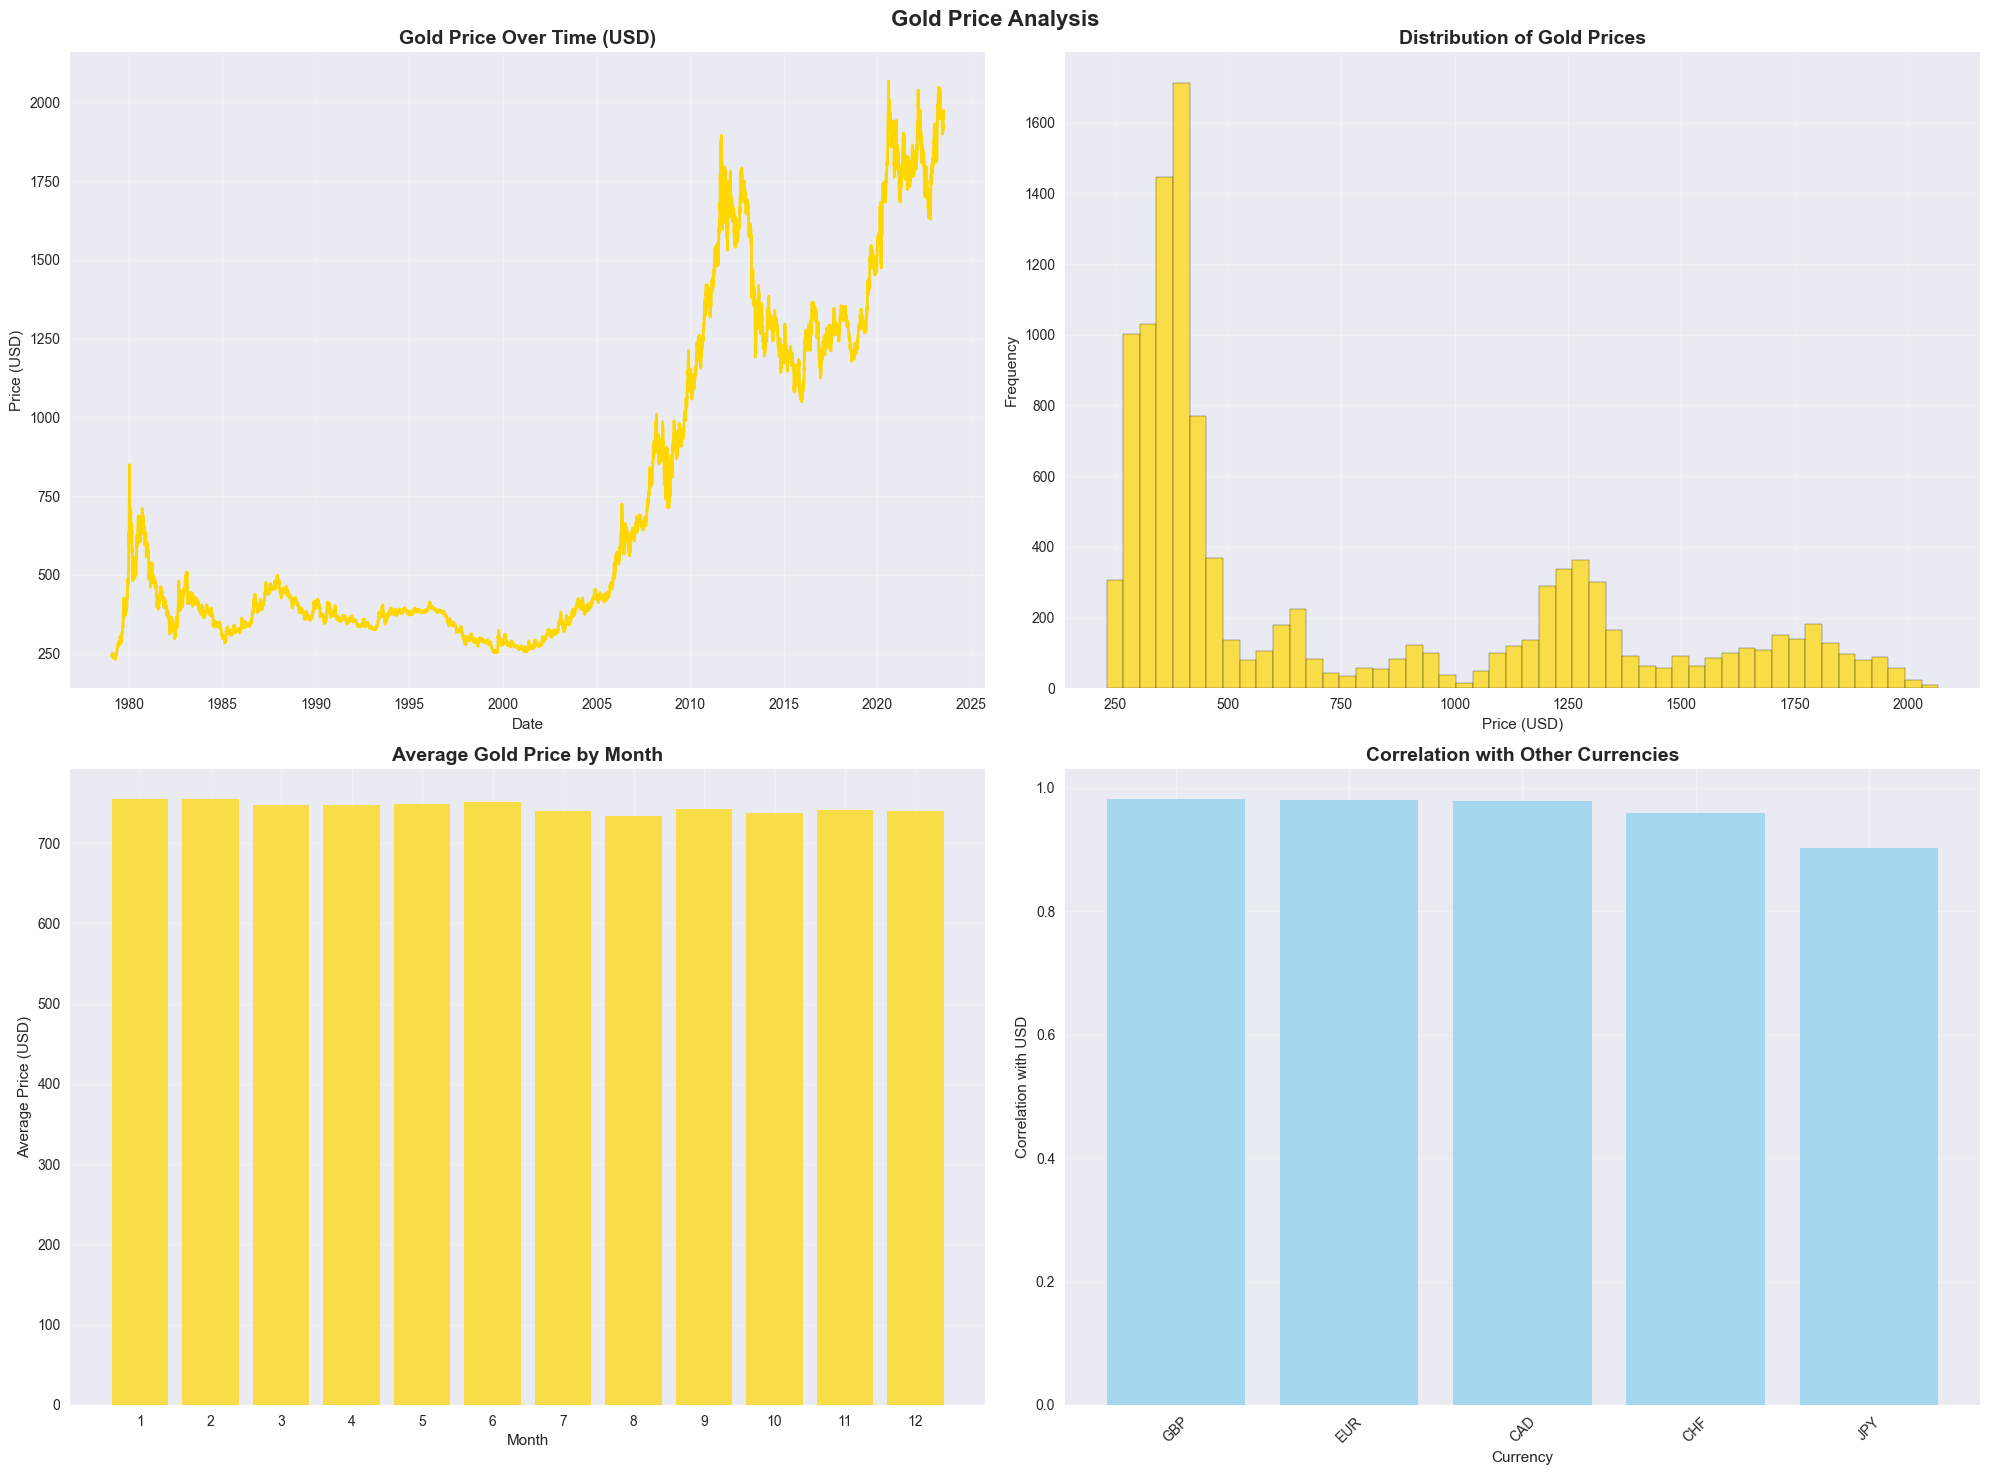


=== GOLD PRICE STATISTICS ===
Average Price: $744.88
Median Price: $426.25
Standard Deviation: $519.61
Minimum Price: $231.90
Maximum Price: $2067.20
Price Range: $1835.30


In [7]:
# Exploratory Data Analysis
def perform_eda(df):
    """
    Comprehensive Exploratory Data Analysis
    """
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Gold Price Analysis', fontsize=16, fontweight='bold')
    
    # 1. Time series plot
    axes[0, 0].plot(df['Date'], df['USD'], linewidth=2, color='gold')
    axes[0, 0].set_title('Gold Price Over Time (USD)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price (USD)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribution of gold prices
    axes[0, 1].hist(df['USD'], bins=50, alpha=0.7, color='gold', edgecolor='black')
    axes[0, 1].set_title('Distribution of Gold Prices', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Price (USD)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Monthly seasonality
    monthly_avg = df.groupby(df['Date'].dt.month)['USD'].mean()
    axes[1, 0].bar(monthly_avg.index, monthly_avg.values, color='gold', alpha=0.7)
    axes[1, 0].set_title('Average Gold Price by Month', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Average Price (USD)')
    axes[1, 0].set_xticks(range(1, 13))
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Correlation with other currencies (top 5)
    currency_cols = ['EUR', 'GBP', 'JPY', 'CAD', 'CHF']
    available_currencies = [col for col in currency_cols if col in df.columns]
    
    if available_currencies:
        correlations = df[['USD'] + available_currencies].corr()['USD'].sort_values(ascending=False)[1:6]
        axes[1, 1].bar(correlations.index, correlations.values, color='skyblue', alpha=0.7)
        axes[1, 1].set_title('Correlation with Other Currencies', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Currency')
        axes[1, 1].set_ylabel('Correlation with USD')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print("\n=== GOLD PRICE STATISTICS ===")
    print(f"Average Price: ${df['USD'].mean():.2f}")
    print(f"Median Price: ${df['USD'].median():.2f}")
    print(f"Standard Deviation: ${df['USD'].std():.2f}")
    print(f"Minimum Price: ${df['USD'].min():.2f}")
    print(f"Maximum Price: ${df['USD'].max():.2f}")
    print(f"Price Range: ${df['USD'].max() - df['USD'].min():.2f}")
    
    return df

# Perform EDA
df_analyzed = perform_eda(df_processed)

In [8]:
# Feature Selection and Preparation
def prepare_features(df):
    """
    Prepare features for machine learning
    """
    # Define target variable
    target = 'USD'
    
    # Select features (exclude Date and target)
    feature_cols = [col for col in df.columns if col not in ['Date', target]]
    
    # Handle any remaining missing values
    df_features = df[feature_cols].fillna(df[feature_cols].mean())
    
    # Feature selection using SelectKBest
    selector = SelectKBest(score_func=f_regression, k=min(20, len(feature_cols)))
    X_selected = selector.fit_transform(df_features, df[target])
    
    # Get selected feature names
    selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
    
    print(f"Selected {len(selected_features)} features out of {len(feature_cols)}")
    print("Top selected features:")
    feature_scores = list(zip(selected_features, selector.scores_[selector.get_support()]))
    feature_scores.sort(key=lambda x: x[1], reverse=True)
    for feature, score in feature_scores[:10]:
        print(f"  {feature}: {score:.2f}")
    
    return pd.DataFrame(X_selected, columns=selected_features), df[target], selected_features

# Prepare features
X, y, feature_names = prepare_features(df_processed)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Selected 20 features out of 37
Top selected features:
  AED: 244740321.06
  USD_MA_3: 57518947.21
  USD_lag_1: 31463283.33
  USD_MA_7: 17701284.37
  SAR: 15572094.93
  USD_lag_3: 10842495.48
  USD_MA_14: 8242410.36
  USD_lag_7: 4817221.24
  USD_MA_30: 3719627.01
  USD_lag_14: 2476683.16

Feature matrix shape: (11596, 20)
Target variable shape: (11596,)


In [10]:
# Train-Test Split
# Use time-based split to avoid data leakage
split_date = df_processed['Date'].quantile(0.8)  # 80% for training

# Method 1: Reset indices to ensure alignment
df_processed_reset = df_processed.reset_index(drop=True)
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True)

train_idx = df_processed_reset['Date'] <= split_date
test_idx = df_processed_reset['Date'] > split_date

X_train = X_reset[train_idx].reset_index(drop=True)
X_test = X_reset[test_idx].reset_index(drop=True)
y_train = y_reset[train_idx].reset_index(drop=True)
y_test = y_reset[test_idx].reset_index(drop=True)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training date range: {df_processed_reset.loc[train_idx, 'Date'].min()} to {df_processed_reset.loc[train_idx, 'Date'].max()}")
print(f"Test date range: {df_processed_reset.loc[test_idx, 'Date'].min()} to {df_processed_reset.loc[test_idx, 'Date'].max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set size: 9277 samples
Test set size: 2319 samples
Training date range: 1979-02-09 00:00:00 to 2014-09-01 00:00:00
Test date range: 2014-09-02 00:00:00 to 2023-07-21 00:00:00


In [11]:
# Define Multiple Machine Learning Models
def initialize_models():
    """
    Initialize various machine learning models
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'Support Vector Regression': SVR(kernel='rbf'),
        'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
    }
    
    return models

# Initialize models
models = initialize_models()
print(f"Initialized {len(models)} models for comparison")

Initialized 9 models for comparison


In [12]:
# Model Training and Evaluation
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    """
    Train and evaluate all models
    """
    results = {}
    predictions = {}
    
    # Models that work better with scaled data
    scaled_models = ['Support Vector Regression', 'K-Nearest Neighbors']
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        try:
            # Use scaled data for certain models
            if name in scaled_models:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                # Cross-validation with scaled data
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                # Cross-validation with original data
                cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Store results
            results[name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'CV_R2_mean': cv_scores.mean(),
                'CV_R2_std': cv_scores.std(),
                'Model': model
            }
            
            predictions[name] = y_pred
            
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAE: {mae:.2f}")
            print(f"  R²: {r2:.4f}")
            print(f"  CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            
        except Exception as e:
            print(f"  Error training {name}: {str(e)}")
            continue
    
    return results, predictions

# Train and evaluate all models
results, predictions = train_and_evaluate_models(
    models, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled
)


Training Linear Regression...
  RMSE: 2.80
  MAE: 2.13
  R²: 0.9999
  CV R² (mean ± std): 0.9949 ± 0.0067

Training Ridge Regression...
  RMSE: 2.80
  MAE: 2.13
  R²: 0.9999
  CV R² (mean ± std): 0.9949 ± 0.0067

Training Lasso Regression...
  RMSE: 17.18
  MAE: 13.54
  R²: 0.9965
  CV R² (mean ± std): 0.7901 ± 0.2991

Training Decision Tree...
  RMSE: 25.36
  MAE: 10.94
  R²: 0.9923
  CV R² (mean ± std): 0.4274 ± 1.0270

Training Random Forest...
  RMSE: 26.54
  MAE: 13.02
  R²: 0.9915
  CV R² (mean ± std): 0.3614 ± 1.1823

Training Gradient Boosting...
  RMSE: 32.44
  MAE: 20.44
  R²: 0.9874
  CV R² (mean ± std): 0.4250 ± 1.1071

Training AdaBoost...
  RMSE: 51.55
  MAE: 30.48
  R²: 0.9681
  CV R² (mean ± std): 0.2606 ± 0.9731

Training Support Vector Regression...
  RMSE: 484.66
  MAE: 318.99
  R²: -1.8194
  CV R² (mean ± std): -0.5375 ± 2.9079

Training K-Nearest Neighbors...
  RMSE: 92.54
  MAE: 83.76
  R²: 0.8972
  CV R² (mean ± std): 0.0701 ± 1.5426


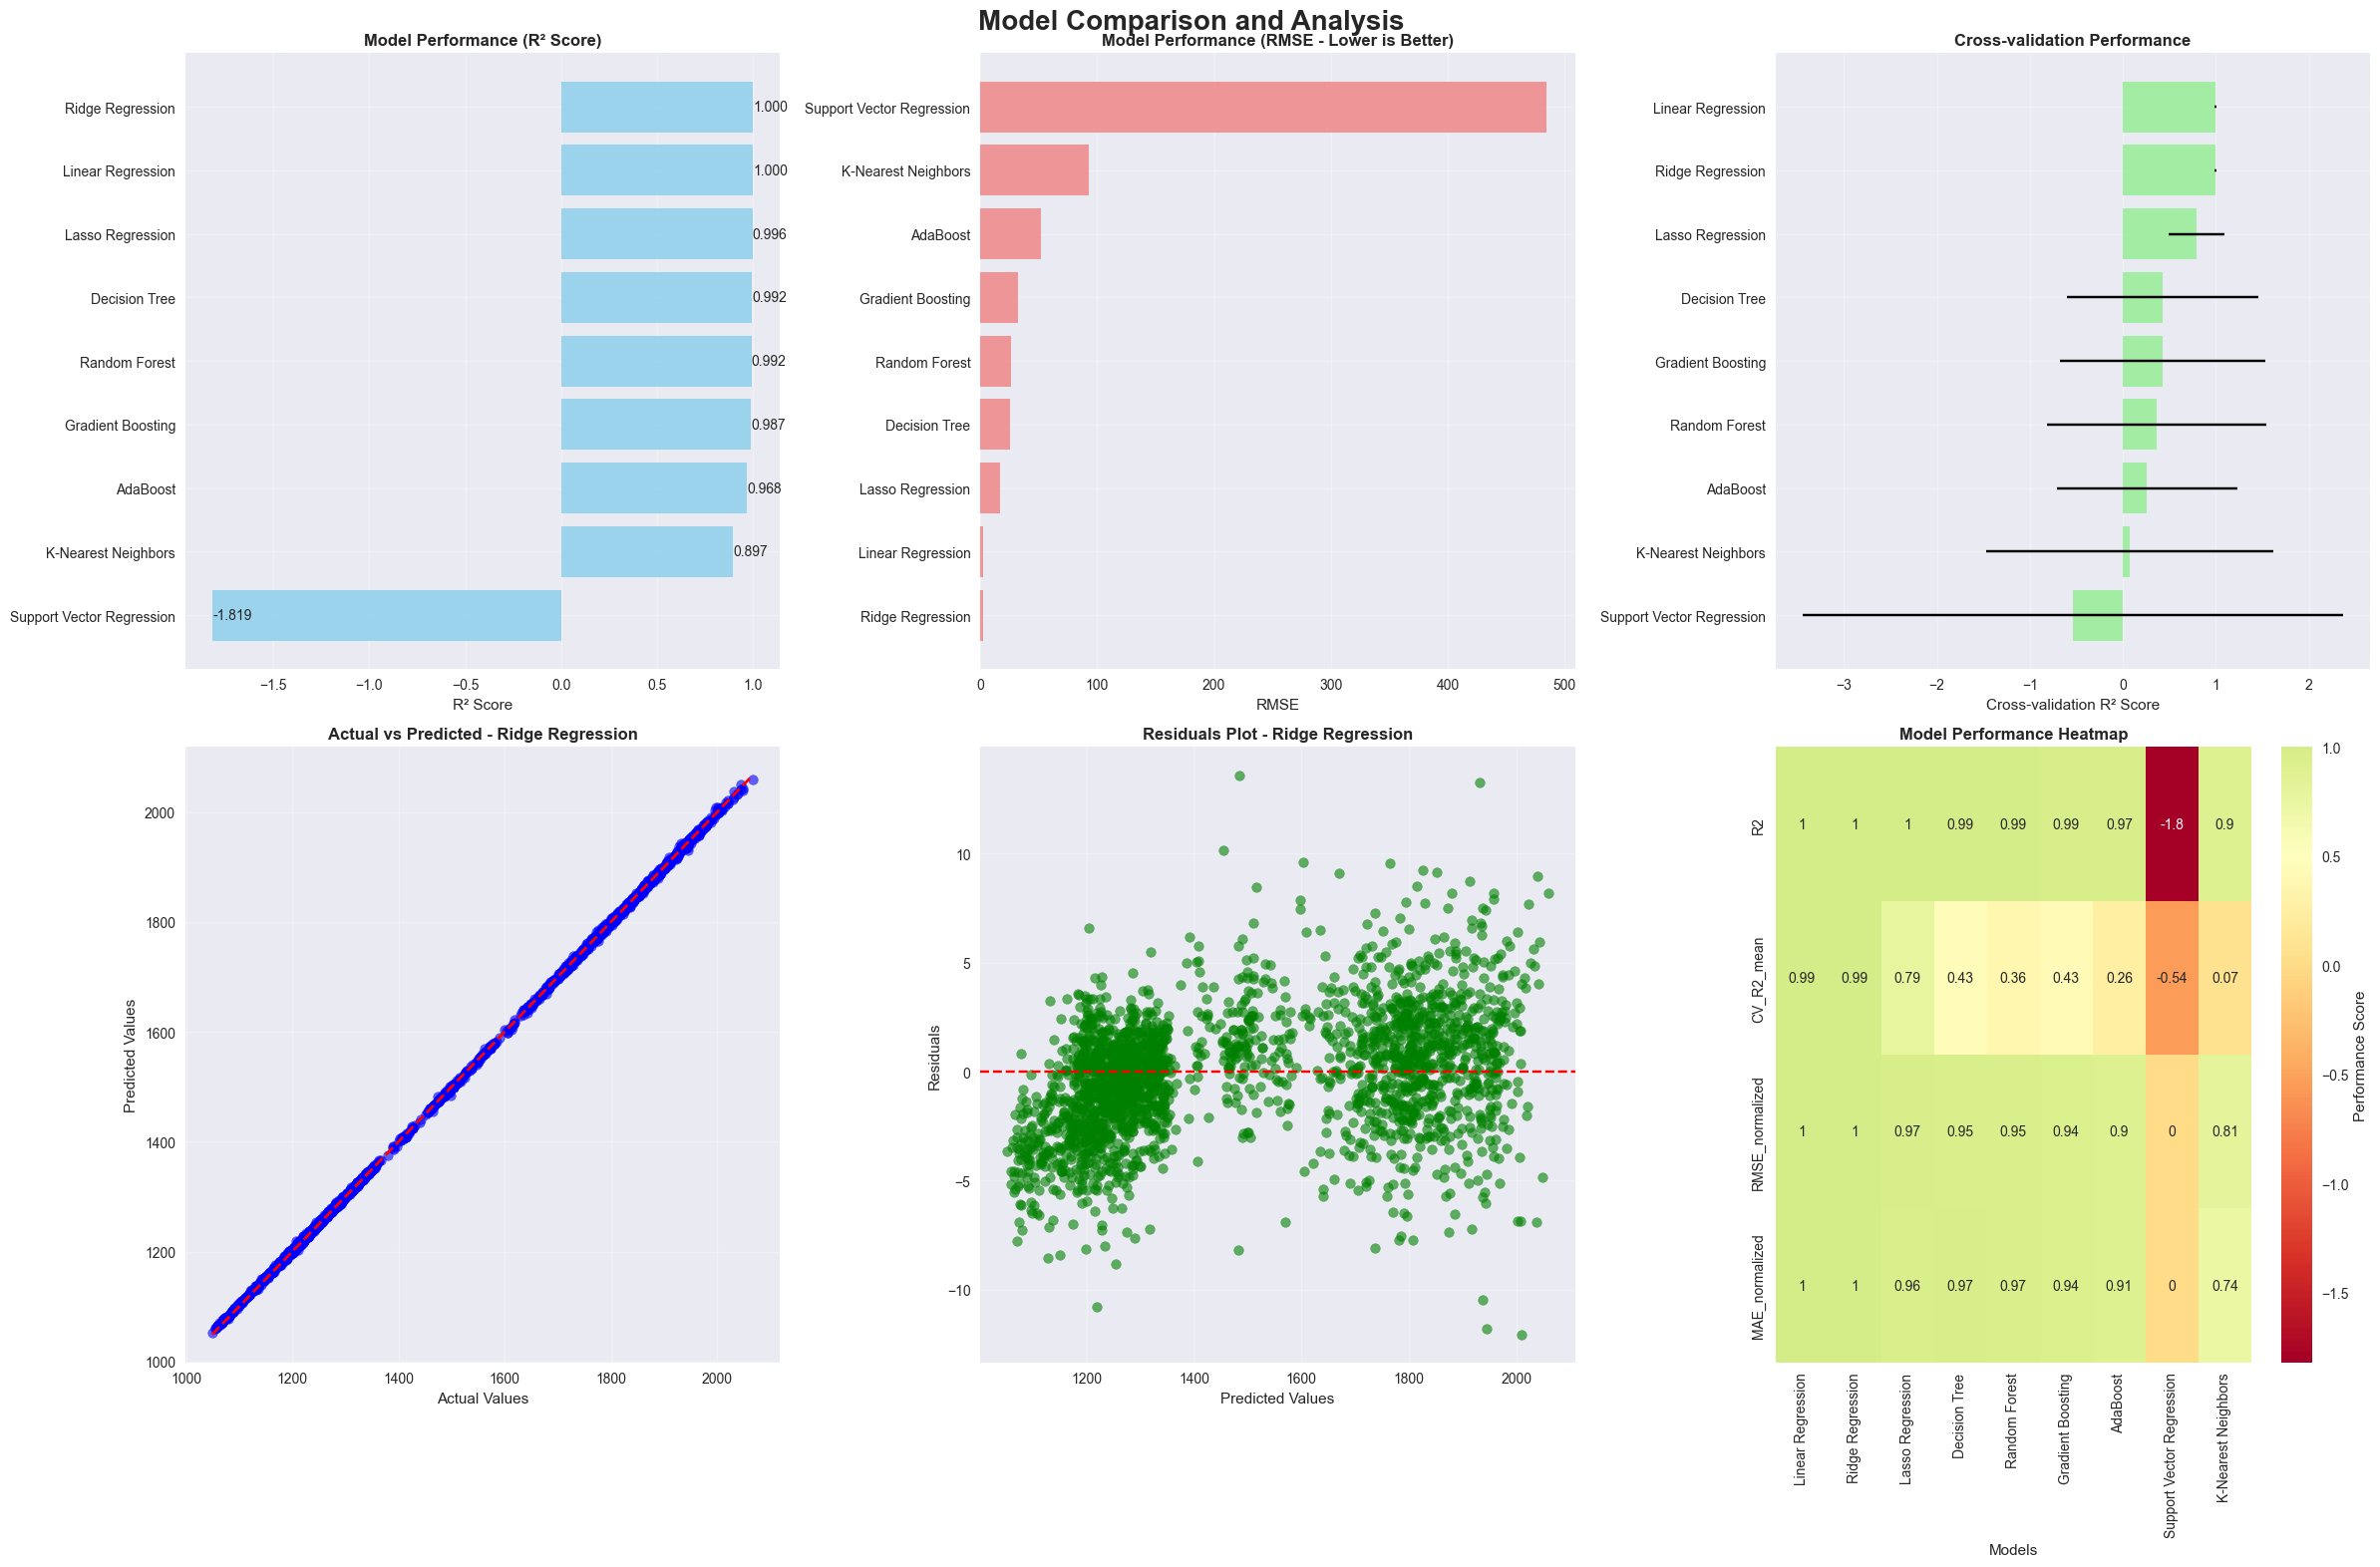


MODEL PERFORMANCE SUMMARY

Top 3 Models by R² Score:
1. Ridge Regression:
   R² Score: 0.9999
   RMSE: 2.80
   MAE: 2.13
   CV R²: 0.9949 ± 0.0067

2. Linear Regression:
   R² Score: 0.9999
   RMSE: 2.80
   MAE: 2.13
   CV R²: 0.9949 ± 0.0067

3. Lasso Regression:
   R² Score: 0.9965
   RMSE: 17.18
   MAE: 13.54
   CV R²: 0.7901 ± 0.2991



In [13]:
# Model Comparison Visualization
def visualize_model_comparison(results, predictions, y_test):
    """
    Create comprehensive visualizations for model comparison
    """
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.drop('Model', axis=1).astype(float)
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('Model Comparison and Analysis', fontsize=20, fontweight='bold')
    
    # 1. R² Score Comparison
    r2_scores = results_df['R2'].sort_values(ascending=True)
    axes[0, 0].barh(range(len(r2_scores)), r2_scores.values, color='skyblue', alpha=0.8)
    axes[0, 0].set_yticks(range(len(r2_scores)))
    axes[0, 0].set_yticklabels(r2_scores.index)
    axes[0, 0].set_xlabel('R² Score')
    axes[0, 0].set_title('Model Performance (R² Score)', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(r2_scores.values):
        axes[0, 0].text(v + 0.001, i, f'{v:.3f}', va='center')
    
    # 2. RMSE Comparison
    rmse_scores = results_df['RMSE'].sort_values(ascending=True)
    axes[0, 1].barh(range(len(rmse_scores)), rmse_scores.values, color='lightcoral', alpha=0.8)
    axes[0, 1].set_yticks(range(len(rmse_scores)))
    axes[0, 1].set_yticklabels(rmse_scores.index)
    axes[0, 1].set_xlabel('RMSE')
    axes[0, 1].set_title('Model Performance (RMSE - Lower is Better)', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Cross-validation R² with error bars
    cv_mean = results_df['CV_R2_mean'].sort_values(ascending=True)
    cv_std = results_df.loc[cv_mean.index, 'CV_R2_std']
    
    axes[0, 2].barh(range(len(cv_mean)), cv_mean.values, 
                   xerr=cv_std.values, color='lightgreen', alpha=0.8, capsize=5)
    axes[0, 2].set_yticks(range(len(cv_mean)))
    axes[0, 2].set_yticklabels(cv_mean.index)
    axes[0, 2].set_xlabel('Cross-validation R² Score')
    axes[0, 2].set_title('Cross-validation Performance', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Actual vs Predicted for best model
    best_model_name = results_df['R2'].idxmax()
    best_predictions = predictions[best_model_name]
    
    axes[1, 0].scatter(y_test, best_predictions, alpha=0.6, color='blue')
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1, 0].set_xlabel('Actual Values')
    axes[1, 0].set_ylabel('Predicted Values')
    axes[1, 0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Residuals plot for best model
    residuals = y_test - best_predictions
    axes[1, 1].scatter(best_predictions, residuals, alpha=0.6, color='green')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].set_title(f'Residuals Plot - {best_model_name}', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Model comparison heatmap
    metrics_for_heatmap = results_df[['R2', 'CV_R2_mean']].copy()
    # Normalize RMSE and MAE (invert so higher is better)
    metrics_for_heatmap['RMSE_normalized'] = 1 - (results_df['RMSE'] - results_df['RMSE'].min()) / (results_df['RMSE'].max() - results_df['RMSE'].min())
    metrics_for_heatmap['MAE_normalized'] = 1 - (results_df['MAE'] - results_df['MAE'].min()) / (results_df['MAE'].max() - results_df['MAE'].min())
    
    sns.heatmap(metrics_for_heatmap.T, annot=True, cmap='RdYlGn', center=0.5, 
                ax=axes[1, 2], cbar_kws={'label': 'Performance Score'})
    axes[1, 2].set_title('Model Performance Heatmap', fontweight='bold')
    axes[1, 2].set_xlabel('Models')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*50)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*50)
    
    print("\nTop 3 Models by R² Score:")
    top_models = results_df.sort_values('R2', ascending=False).head(3)
    for i, (model_name, row) in enumerate(top_models.iterrows(), 1):
        print(f"{i}. {model_name}:")
        print(f"   R² Score: {row['R2']:.4f}")
        print(f"   RMSE: {row['RMSE']:.2f}")
        print(f"   MAE: {row['MAE']:.2f}")
        print(f"   CV R²: {row['CV_R2_mean']:.4f} ± {row['CV_R2_std']:.4f}")
        print()
    
    return results_df, best_model_name

# Create visualizations
results_df, best_model_name = visualize_model_comparison(results, predictions, y_test)

In [14]:
# Hyperparameter Tuning for Best Model
def tune_best_model(best_model_name, results, X_train, y_train):
    """
    Perform hyperparameter tuning for the best performing model
    """
    print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
    
    # Define parameter grids for different models
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Support Vector Regression': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'epsilon': [0.01, 0.1, 0.2]
        },
        'Ridge Regression': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        },
        'Lasso Regression': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        }
    }
    
    if best_model_name in param_grids:
        # Get the model
        best_model = results[best_model_name]['Model']
        param_grid = param_grids[best_model_name]
        
        # Perform grid search
        grid_search = GridSearchCV(
            best_model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1
        )
        
        # Use scaled data for SVR
        if best_model_name == 'Support Vector Regression':
            grid_search.fit(X_train_scaled, y_train)
        else:
            grid_search.fit(X_train, y_train)
        
        print(f"\nBest parameters for {best_model_name}:")
        print(grid_search.best_params_)
        print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    else:
        print(f"No hyperparameter tuning defined for {best_model_name}")
        return results[best_model_name]['Model']

# Tune the best model
tuned_model = tune_best_model(best_model_name, results, X_train, y_train)


Performing hyperparameter tuning for Ridge Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters for Ridge Regression:
{'alpha': 0.1}
Best cross-validation R² score: 0.9949



Training LSTM model...
73/73 [==============================] - 1s 2ms/step
LSTM Model Performance:
  RMSE: 767.25
  MAE: 711.75
  R²: -6.0657


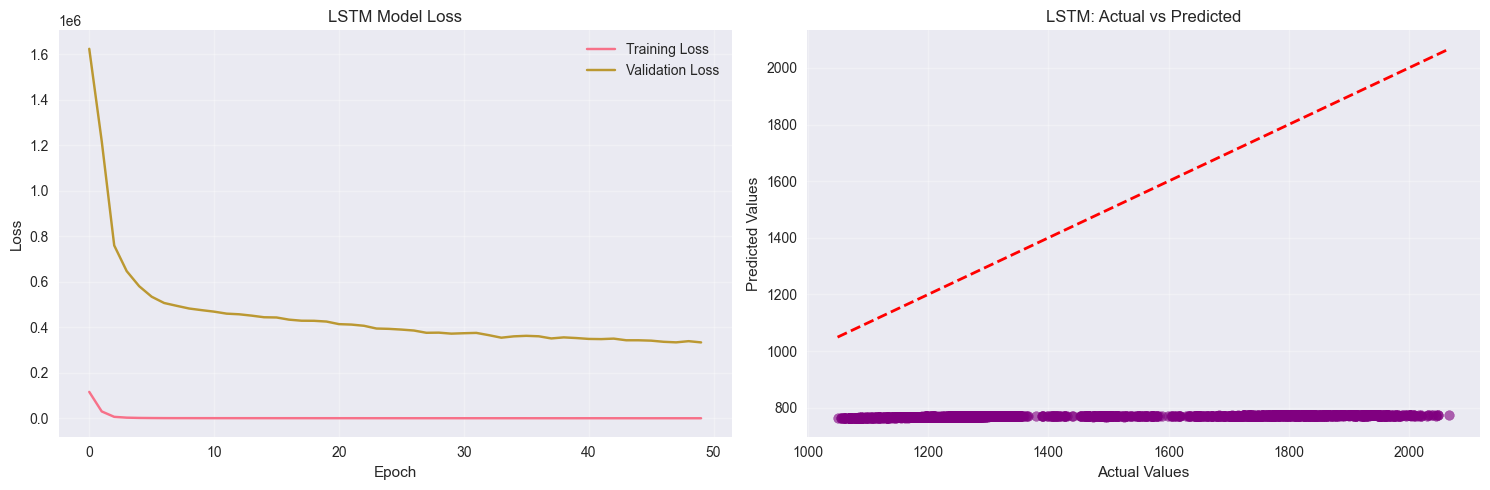

In [15]:
# LSTM Model (if TensorFlow is available)
if TENSORFLOW_AVAILABLE:
    def create_lstm_model(X_train, y_train, X_test, y_test):
        """
        Create and train LSTM model for time series prediction
        """
        print("\nTraining LSTM model...")
        
        # Reshape data for LSTM (samples, time steps, features)
        X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
        
        # Create LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        
        # Compile model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        
        # Train model
        history = model.fit(
            X_train_lstm, y_train,
            batch_size=32,
            epochs=50,
            validation_split=0.2,
            verbose=0
        )
        
        # Make predictions
        y_pred_lstm = model.predict(X_test_lstm).flatten()
        
        # Calculate metrics
        mse_lstm = mean_squared_error(y_test, y_pred_lstm)
        rmse_lstm = np.sqrt(mse_lstm)
        mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
        r2_lstm = r2_score(y_test, y_pred_lstm)
        
        print(f"LSTM Model Performance:")
        print(f"  RMSE: {rmse_lstm:.2f}")
        print(f"  MAE: {mae_lstm:.2f}")
        print(f"  R²: {r2_lstm:.4f}")
        
        # Plot training history
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('LSTM Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.scatter(y_test, y_pred_lstm, alpha=0.6, color='purple')
        ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax2.set_xlabel('Actual Values')
        ax2.set_ylabel('Predicted Values')
        ax2.set_title('LSTM: Actual vs Predicted')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return model, y_pred_lstm, r2_lstm
    
    # Train LSTM model
    lstm_model, lstm_predictions, lstm_r2 = create_lstm_model(X_train, y_train, X_test, y_test)
else:
    print("\nTensorFlow not available. Skipping LSTM model.")


FINAL TUNED MODEL PERFORMANCE: Ridge Regression
RMSE: $2.80
MAE: $2.13
R² Score: 0.9999
Mean Absolute Percentage Error: 0.15%


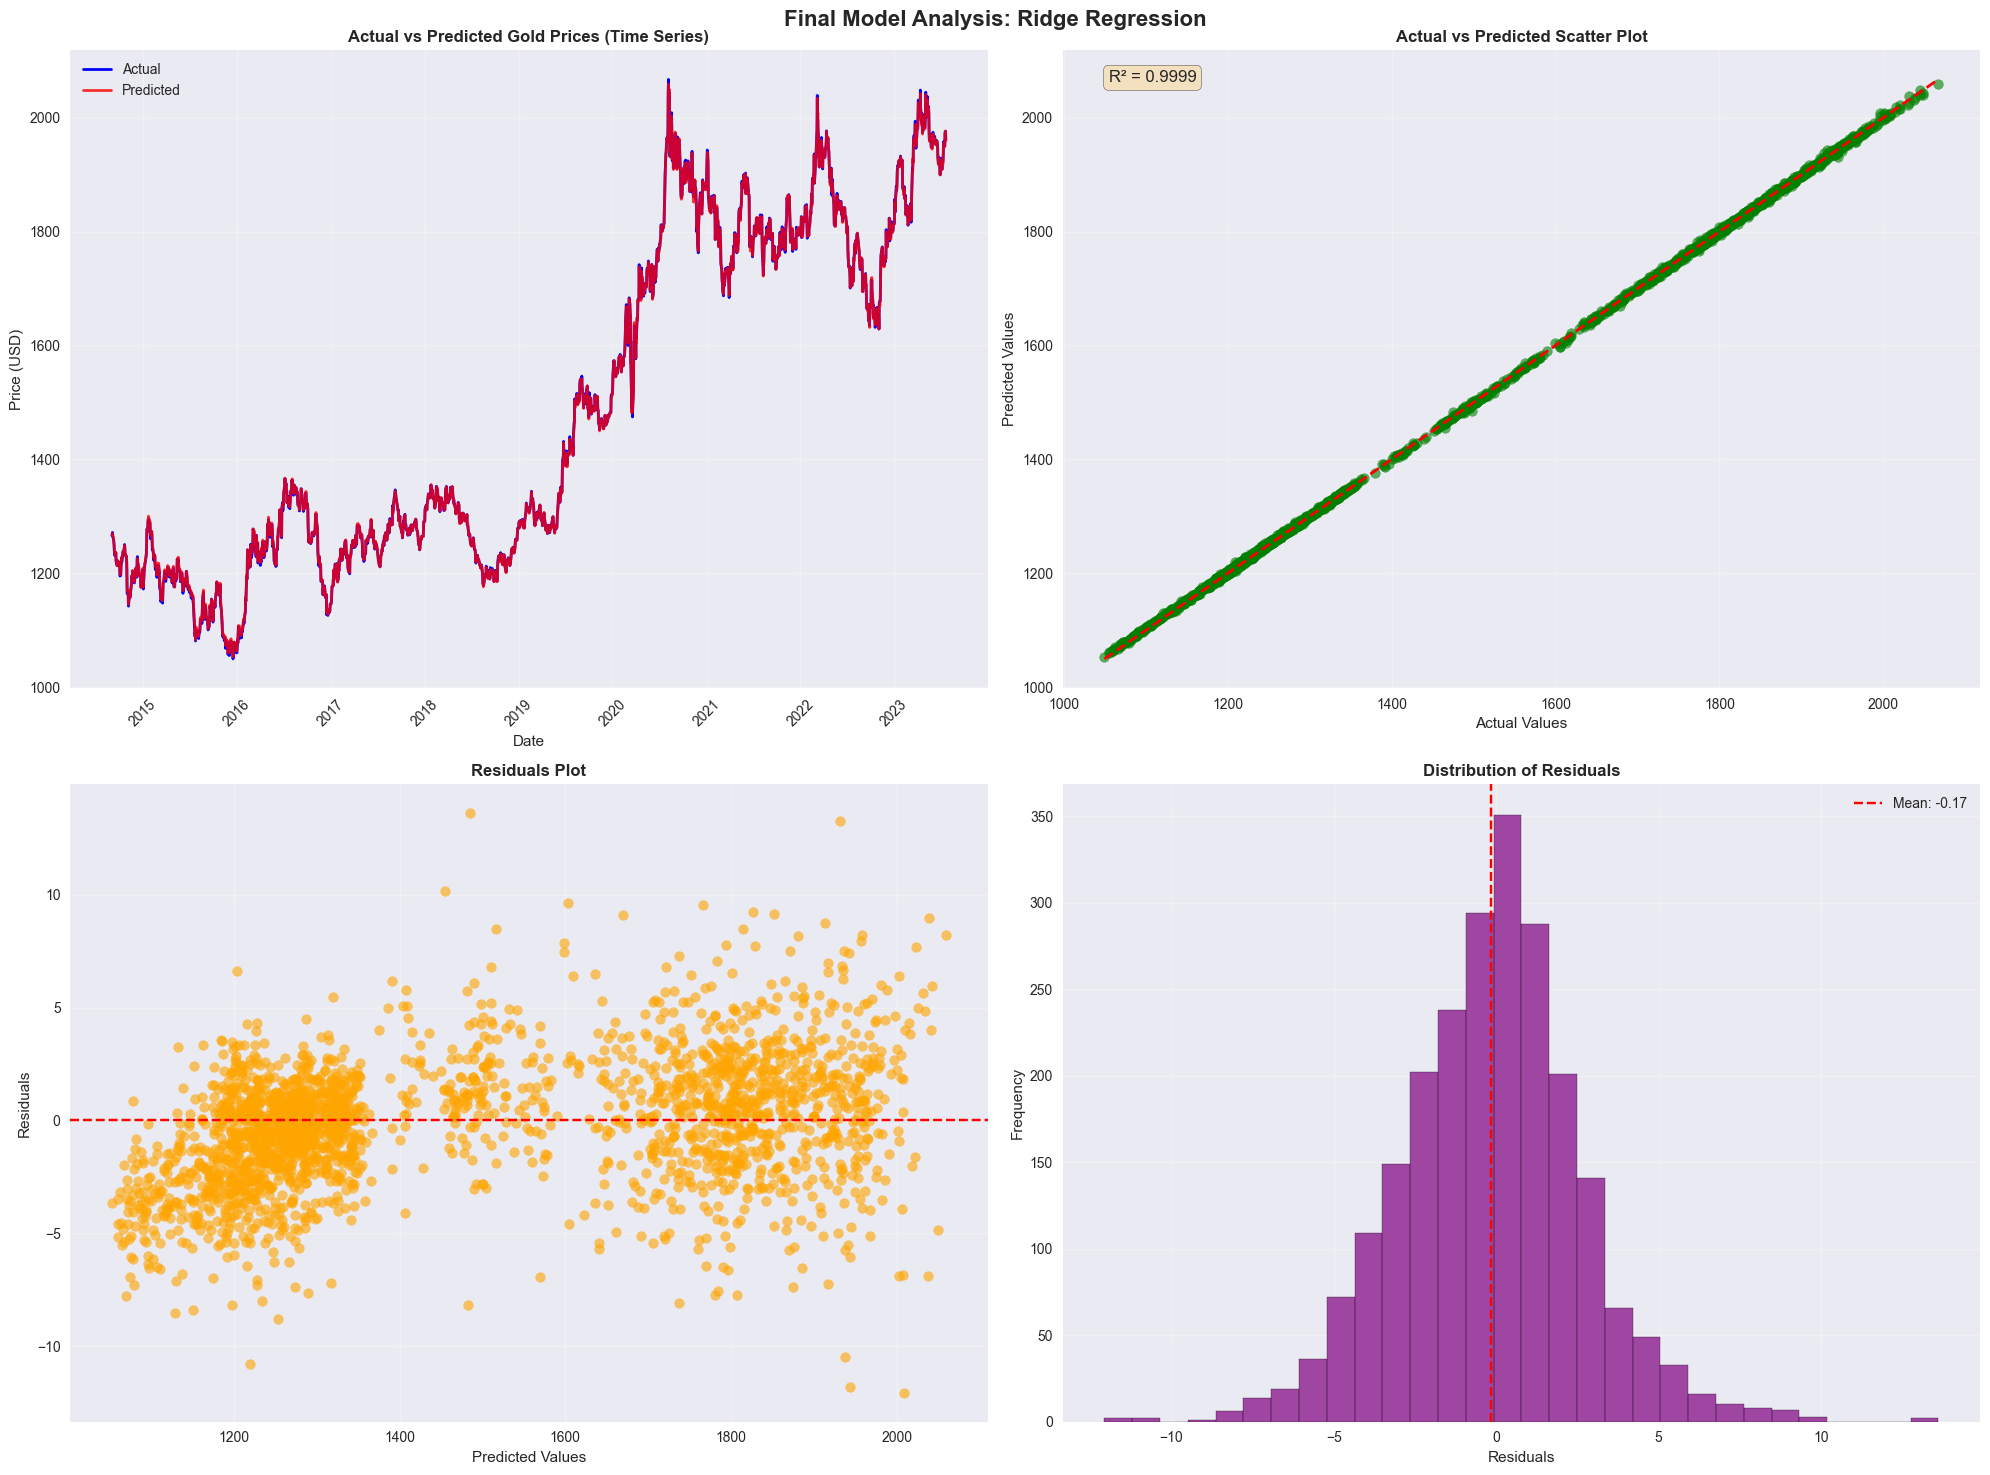

In [17]:
# Final Model Evaluation and Prediction Visualization
def final_evaluation_and_visualization(tuned_model, best_model_name, X_test, y_test, df_processed, test_idx, scaler=None):
    """
    Final evaluation and create prediction visualizations
    """
    # Make final predictions - handle scaled data properly
    if best_model_name == 'Support Vector Regression' and scaler is not None:
        X_test_scaled = scaler.transform(X_test)
        final_predictions = tuned_model.predict(X_test_scaled)
    else:
        final_predictions = tuned_model.predict(X_test)
    
    # Calculate final metrics
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)
    final_mae = mean_absolute_error(y_test, final_predictions)
    final_r2 = r2_score(y_test, final_predictions)
    
    print(f"\n{'='*60}")
    print(f"FINAL TUNED MODEL PERFORMANCE: {best_model_name}")
    print(f"{'='*60}")
    print(f"RMSE: ${final_rmse:.2f}")
    print(f"MAE: ${final_mae:.2f}")
    print(f"R² Score: {final_r2:.4f}")
    print(f"Mean Absolute Percentage Error: {np.mean(np.abs((y_test - final_predictions) / y_test)) * 100:.2f}%")
    
    # Create comprehensive prediction visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(f'Final Model Analysis: {best_model_name}', fontsize=16, fontweight='bold')
    
    # Fix indexing issue by resetting indices and aligning properly
    df_reset = df_processed.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    
    # Get test dates - handle different types of test_idx
    if isinstance(test_idx, (pd.Series, np.ndarray)) and len(test_idx) == len(df_processed):
        # If test_idx is a boolean mask for the full df_processed
        test_dates = df_reset.loc[test_idx.reset_index(drop=True) if hasattr(test_idx, 'reset_index') else test_idx, 'Date'].reset_index(drop=True)
    else:
        # If test_idx contains positional indices
        test_dates = df_reset.iloc[test_idx]['Date'].reset_index(drop=True)
    
    # Ensure all arrays have the same length
    min_length = min(len(test_dates), len(y_test_reset), len(final_predictions))
    test_dates = test_dates.iloc[:min_length]
    y_test_plot = y_test_reset.iloc[:min_length]
    final_pred_plot = final_predictions[:min_length]
    
    # 1. Time series prediction plot
    axes[0, 0].plot(test_dates, y_test_plot, label='Actual', linewidth=2, color='blue')
    axes[0, 0].plot(test_dates, final_pred_plot, label='Predicted', linewidth=2, color='red', alpha=0.8)
    axes[0, 0].set_title('Actual vs Predicted Gold Prices (Time Series)', fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price (USD)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Scatter plot: Actual vs Predicted
    axes[0, 1].scatter(y_test_reset, final_predictions, alpha=0.6, color='green')
    axes[0, 1].plot([y_test_reset.min(), y_test_reset.max()], [y_test_reset.min(), y_test_reset.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Actual vs Predicted Scatter Plot', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add R² score to the plot
    axes[0, 1].text(0.05, 0.95, f'R² = {final_r2:.4f}', transform=axes[0, 1].transAxes, 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=12)
    
    # 3. Residuals analysis
    residuals = y_test_reset - final_predictions
    axes[1, 0].scatter(final_predictions, residuals, alpha=0.6, color='orange')
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Error distribution
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(x=residuals.mean(), color='red', linestyle='--', 
                      label=f'Mean: {residuals.mean():.2f}')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Residuals', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return tuned_model, final_predictions

# Final evaluation - Updated function call with scaler parameter
final_model, final_pred = final_evaluation_and_visualization(
    tuned_model, best_model_name, X_test, y_test, df_processed, test_idx, scaler=scaler
)



Feature Importance Analysis for Ridge Regression
Top 10 Most Important Features (Coefficient Magnitudes):
 1. USD_MA_3                  0.669637
 2. USD_lag_1                 0.261882
 3. AED                       0.154739
 4. USD_lag_3                 0.094643
 5. USD_MA_7                  0.052727
 6. SAR                       0.038139
 7. USD_MA_14                 0.033182
 8. GBP                       0.019328
 9. CAD                       0.018635
10. EUR                       0.015438


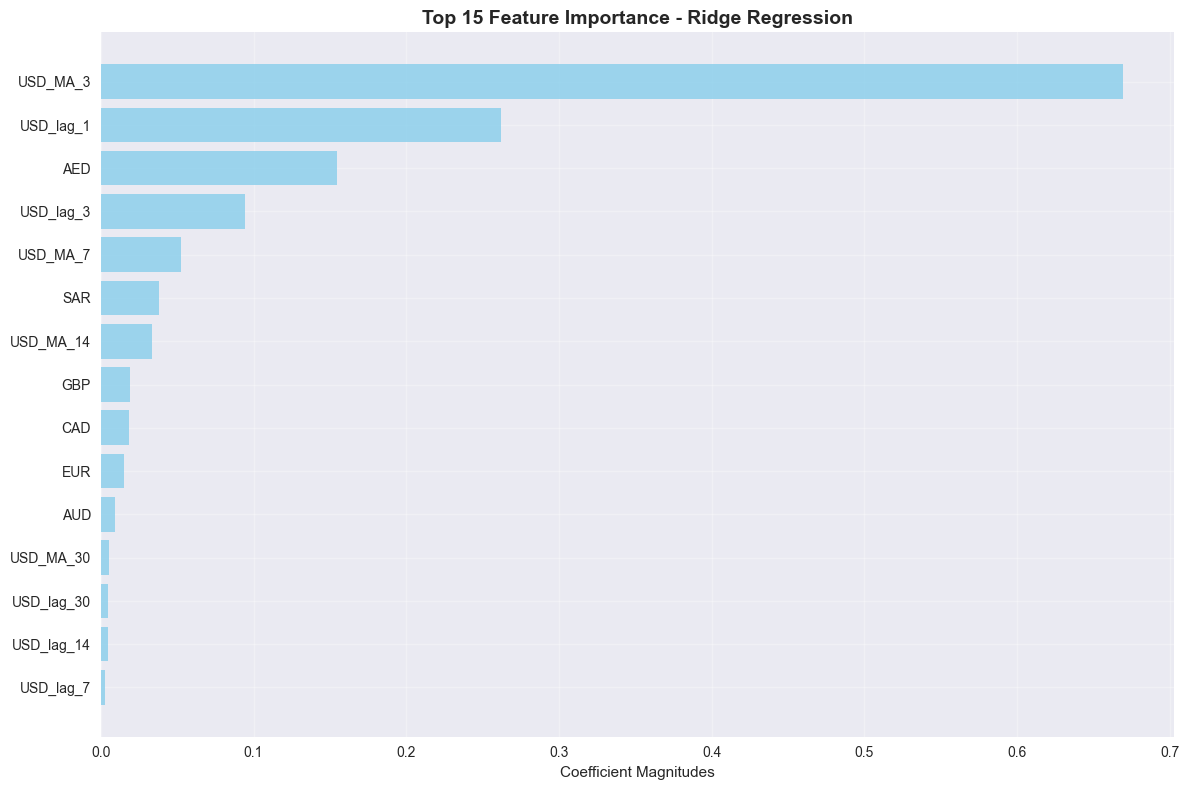

In [18]:
# Feature Importance Analysis
def analyze_feature_importance(model, feature_names, model_name):
    """
    Analyze and visualize feature importance
    """
    print(f"\nFeature Importance Analysis for {model_name}")
    print("="*50)
    
    # Get feature importance based on model type
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_type = 'Feature Importances'
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        importance_type = 'Coefficient Magnitudes'
    else:
        print(f"Feature importance not available for {model_name}")
        return
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top features
    print(f"Top 10 Most Important Features ({importance_type}):")
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<25} {row['Importance']:.6f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel(f'{importance_type}')
    plt.title(f'Top 15 Feature Importance - {model_name}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(final_model, feature_names, best_model_name)

In [19]:
# Save the Final Model
def save_model_and_components(model, scaler, feature_names, model_name):
    """
    Save the trained model and necessary components
    """
    import os
    
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save model
    model_filename = f'models/gold_price_prediction_{model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, model_filename)
    
    # Save scaler
    scaler_filename = f'models/scaler_{model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(scaler, scaler_filename)
    
    # Save feature names
    features_filename = f'models/features_{model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(feature_names, features_filename)
    
    print(f"\nModel saved successfully!")
    print(f"Model file: {model_filename}")
    print(f"Scaler file: {scaler_filename}")
    print(f"Features file: {features_filename}")
    
    return model_filename, scaler_filename, features_filename

# Save the model
model_files = save_model_and_components(final_model, scaler, feature_names, best_model_name)


Model saved successfully!
Model file: models/gold_price_prediction_ridge_regression.pkl
Scaler file: models/scaler_ridge_regression.pkl
Features file: models/features_ridge_regression.pkl


In [20]:
# Prediction Function for New Data
def predict_gold_price(model, scaler, feature_names, new_data, model_name):
    """
    Function to make predictions on new data
    """
    # Ensure new_data has the same features as training data
    if isinstance(new_data, dict):
        new_data_df = pd.DataFrame([new_data])
    else:
        new_data_df = new_data.copy()
    
    # Select only the required features
    new_data_selected = new_data_df[feature_names]
    
    # Scale the data if needed
    if model_name == 'Support Vector Regression':
        new_data_scaled = scaler.transform(new_data_selected)
        prediction = model.predict(new_data_scaled)
    else:
        prediction = model.predict(new_data_selected)
    
    return prediction[0] if len(prediction) == 1 else prediction

# Example usage with sample data
if len(X_test) > 0:
    sample_data = X_test.iloc[0].to_dict()
    sample_prediction = predict_gold_price(final_model, scaler, feature_names, sample_data, best_model_name)
    actual_value = y_test.iloc[0]
    
    print(f"\nSample Prediction Example:")
    print(f"Predicted Gold Price: ${sample_prediction:.2f}")
    print(f"Actual Gold Price: ${actual_value:.2f}")
    print(f"Prediction Error: ${abs(sample_prediction - actual_value):.2f}")
    print(f"Percentage Error: {abs(sample_prediction - actual_value) / actual_value * 100:.2f}%")


Sample Prediction Example:
Predicted Gold Price: $1268.24
Actual Gold Price: $1267.00
Prediction Error: $1.24
Percentage Error: 0.10%


In [21]:
# Project Summary and Conclusions
print("\n" + "="*80)
print("GOLD PRICE PREDICTION PROJECT SUMMARY")
print("="*80)

print(f"\n📊 Dataset Information:")
print(f"   • Total samples processed: {len(df_processed)}")
print(f"   • Features created: {len(feature_names)}")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Test samples: {len(X_test)}")

print(f"\n🏆 Best Performing Model: {best_model_name}")
best_results = results[best_model_name]
print(f"   • R² Score: {best_results['R2']:.4f}")
print(f"   • RMSE: ${best_results['RMSE']:.2f}")
print(f"   • MAE: ${best_results['MAE']:.2f}")
print(f"   • Cross-validation R²: {best_results['CV_R2_mean']:.4f} ± {best_results['CV_R2_std']:.4f}")

if TENSORFLOW_AVAILABLE and 'lstm_r2' in locals():
    print(f"\n🧠 LSTM Model Performance:")
    print(f"   • R² Score: {lstm_r2:.4f}")

print(f"\n💡 Key Insights:")
if feature_importance_df is not None:
    top_3_features = feature_importance_df.head(3)['Feature'].tolist()
    print(f"   • Top 3 most important features: {', '.join(top_3_features)}")

print(f"   • Model explains {best_results['R2']*100:.1f}% of gold price variance")
print(f"   • Average prediction error: ${best_results['MAE']:.2f}")

print(f"\n📁 Saved Files:")
for file_path in model_files:
    print(f"   • {file_path}")

print(f"\n🎯 Model Usage:")
print(f"   • Load the saved model using joblib.load()")
print(f"   • Use the predict_gold_price() function for new predictions")
print(f"   • Ensure new data has the same features as training data")

print(f"\n⚠️  Important Notes:")
print(f"   • This model is trained on historical data and may not predict future events")
print(f"   • Consider retraining periodically with new data")
print(f"   • Use predictions as guidance, not as financial advice")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*80)


GOLD PRICE PREDICTION PROJECT SUMMARY

📊 Dataset Information:
   • Total samples processed: 11596
   • Features created: 20
   • Training samples: 9277
   • Test samples: 2319

🏆 Best Performing Model: Ridge Regression
   • R² Score: 0.9999
   • RMSE: $2.80
   • MAE: $2.13
   • Cross-validation R²: 0.9949 ± 0.0067

🧠 LSTM Model Performance:
   • R² Score: -6.0657

💡 Key Insights:
   • Top 3 most important features: USD_MA_3, USD_lag_1, AED
   • Model explains 100.0% of gold price variance
   • Average prediction error: $2.13

📁 Saved Files:
   • models/gold_price_prediction_ridge_regression.pkl
   • models/scaler_ridge_regression.pkl
   • models/features_ridge_regression.pkl

🎯 Model Usage:
   • Load the saved model using joblib.load()
   • Use the predict_gold_price() function for new predictions
   • Ensure new data has the same features as training data

⚠️  Important Notes:
   • This model is trained on historical data and may not predict future events
   • Consider retraining per